In [1]:
# Define a new activation function
# can be applied on label and prediction

In [2]:
# Discrimeter MI estimator (MIT)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import argparse
from torch.autograd import Variable
import itertools
from tqdm import tqdm
from data.mix_gaussian import MixedGaussian
from data.gaussian import Gaussian
from model.utils import *
import pdb

cuda = True if torch.cuda.is_available() else False
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="coefficient of Gaussian")
parser.add_argument("--gamma", type=float, default=0, help="clip the ratio")
parser.add_argument("--d", type=int, default=10, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=400, help="sample size")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=40000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--alpha", type=float, default=0.99, help="RMSprop: smoothing constant ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--confidence", type=float, default=1e-4, help="smooth parameter")

# opt = parser.parse_args()
opt, unknown = parser.parse_known_args()
# adaptive LS parameters
a, b, c = 0.001, 0.1, 0.9

In [4]:
# construct the data
rep = 1
density = 'Gaussian'
# use GPU if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

def generate_data(distribution='Gaussian', rho=0.9):
    # np.random.seed(seed)
    # # initialize random seed
    # torch.manual_seed(seed)
    mu1 = 0
    mu2 = 0

    X = np.zeros((opt.sample_size,opt.d))
    Y = np.zeros((opt.sample_size,opt.d))
    if distribution=='Gaussian':
        mg = Gaussian(sample_size=opt.sample_size,rho=rho)
    else:
        mg = MixedGaussian(sample_size=opt.sample_size,mean1=mu1, mean2=mu2,rho1=rho,rho2=-rho)
    mi = mg.ground_truth * opt.d
    data = mg.data
    for j in range(opt.d):
        data = mg.data
        X[:,j] = data[:,0]
        Y[:,j] = data[:,1]
    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    XY = torch.cat((X, Y), dim=1)
    return XY, X, Y, mi

In [5]:
def acti_func(x, a, b, c):
    # y: a
    # x: 0 b c 1
    alpha = torch.zeros_like(x)
    x_cpu = x.cpu()
    alpha[np.where(x_cpu.cpu()<=b)] = a*x[np.where(x_cpu<=b)]/b + a
    alpha[np.where((x_cpu>b) & (x_cpu<c))] = 0
    alpha[np.where(x_cpu>=c)] = a*x[np.where(x_cpu>=c)]/(1-c) + a*c/(c-1)
    return alpha

class Net(nn.Module):
    # Inner class that defines the neural network architecture
    def __init__(self, input_size=2, hidden_size=100, sigma=0.02):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight, std=sigma)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=sigma)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=sigma)
        nn.init.constant_(self.fc3.bias, 0)

    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = F.sigmoid(self.fc3(output))
        alpha = acti_func(output, a, b, c)
        # alpha = torch.sigmoid(output)
        # output = self.fc3(output)
        return output, alpha

In [6]:
discriminator = Net(input_size=opt.d*2, hidden_size=100)
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# loss
categorical_loss = torch.nn.CrossEntropyLoss()
adversarial_loss = torch.nn.BCELoss()
bcelogit_loss = nn.BCEWithLogitsLoss()

if cuda:
    discriminator.cuda()
    adversarial_loss.cuda()
# Optimizers Adam
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

def _resample(data, batch_size, replace=False):
    # Resample the given data sample.
    index = np.random.choice(
        range(data.shape[0]), size=batch_size, replace=replace)
    batch = data[index]
    return batch

def smooth_ce_loss(pre_label, true_label, smoothing, num_classes):
    new_labels = (1.0 - smoothing) * true_label + smoothing / num_classes
    return adversarial_loss(pred_label, new_labels)

def mi_estimate(model, test_XY, gamma, alpha):
    # clip the output of neural networks
    pre, _ = model(test_XY)
    pre = pre.clamp(min=gamma, max=1-gamma)
    MI_est = torch.log(alpha*pre/((1-pre).clamp(min=gamma, max=1-gamma))).mean()
    # pre = model(test_XY)
    # MI_est = torch.log(alpha*pre/((1-pre))).mean()

    return MI_est

In [7]:
XY, X, Y, Ground_truth = generate_data(distribution=density, rho=opt.rho)
test_XY, _, _, _ = generate_data(distribution=density, rho=opt.rho)

mi_list = []
acc_list = []
testMI_list = []
for i in range(opt.n_iters):
    data_joint = _resample(XY, batch_size=opt.batch_size)
    X_ref = resample(X, batch_size=opt.batch_size)
    Y_ref = resample(Y, batch_size=opt.batch_size)
    data_margin = torch.cat((X_ref, Y_ref), dim=1)
    valid = Variable(Tensor(opt.batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(Tensor(opt.batch_size, 1).fill_(0.0), requires_grad=False)
    train_data = torch.cat((data_joint, data_margin), dim=0)
    labels = torch.cat((valid, fake), dim=0)
    pred_label, confidence = discriminator(train_data)
    # print(confidence)
    alpha = data_margin.shape[0]/data_joint.shape[0]
    
    acc_list.append((torch.tensor([1 if x>0.5 else 0 for x in pred_label]) == labels.flatten()).sum().float()/labels.shape[0])
    optimizer_D.zero_grad()
    # loss = adversarial_loss(pred_label, labels)
    # loss = bcelogit_loss(pred_label, labels)
    # pdb.set_trace()
    loss = smooth_ce_loss(pred_label, labels, confidence.detach(), 2)
    loss.backward()
    optimizer_D.step()
    with torch.no_grad():
        mi_est = mi_estimate(discriminator, XY, opt.gamma, alpha)
        testmi_est = mi_estimate(discriminator, test_XY, opt.gamma, alpha)
        if torch.isinf(mi_est):
            mi_est = torch.from_numpy(np.array(mi_list[-1]))
        if torch.isinf(testmi_est):
            testmi_est = torch.from_numpy(np.array(testMI_list[-1]))
        mi_list.append(mi_est.item())
        testMI_list.append(testmi_est.item())
    if i%500==0:
        print("Iternation: %d, loss: %f, mi_est: %f"%(i, loss.item(), mi_est))

Iternation: 0, loss: 0.693153, mi_est: 0.000051
Iternation: 500, loss: 0.693251, mi_est: 0.000974
Iternation: 1000, loss: 0.674852, mi_est: 0.055373
Iternation: 1500, loss: 0.413082, mi_est: 0.747717
Iternation: 2000, loss: 0.216537, mi_est: 1.749753
Iternation: 2500, loss: 0.120838, mi_est: 2.436970
Iternation: 3000, loss: 0.089448, mi_est: 3.218467
Iternation: 3500, loss: 0.068962, mi_est: 3.566361
Iternation: 4000, loss: 0.070075, mi_est: 4.011139
Iternation: 4500, loss: 0.040513, mi_est: 4.254314
Iternation: 5000, loss: 0.059418, mi_est: 4.362624
Iternation: 5500, loss: 0.044688, mi_est: 4.587692
Iternation: 6000, loss: 0.052702, mi_est: 4.838348
Iternation: 6500, loss: 0.041187, mi_est: 5.019089
Iternation: 7000, loss: 0.055636, mi_est: 5.172025
Iternation: 7500, loss: 0.031413, mi_est: 5.272308
Iternation: 8000, loss: 0.056409, mi_est: 5.345722
Iternation: 8500, loss: 0.019206, mi_est: 5.597024
Iternation: 9000, loss: 0.018736, mi_est: 5.788364
Iternation: 9500, loss: 0.064976, m

In [8]:
ma_rate = 0.01
mi_copy = mi_list.copy()
for k in range(1,len(mi_list)):
    mi_copy[k] = (1-ma_rate) * mi_copy[k-1] + ma_rate * mi_copy[k]

acc_copy = acc_list.copy()
for k in range(1,len(acc_copy)):
    acc_copy[k] = (1-ma_rate) * acc_copy[k-1] + ma_rate * acc_copy[k]

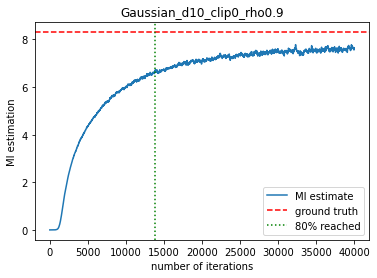

In [9]:
plt.plot(mi_copy, label='MI estimate')
plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
for t in range(len(mi_copy)):
    if (mi_copy[t]>.8*Ground_truth):
        plt.axvline(t,label='80% reached',linestyle=':',color='green')
        break
plt.xlabel('number of iterations')
plt.ylabel('MI estimation')
plt.title('{}_d{}_clip{}_rho{}'.format(density, opt.d, opt.gamma, opt.rho))
plt.legend()
# plt.savefig('./results/DIEM/{}_d{}_clip{}_rho{}.pdf'.format(density, opt.d, opt.gamma, opt.rho))
# plt.savefig('./results/DIEM/NoClip{}_d{}_smooth{}_rho{}.pdf'.format(density, opt.d, opt.confidence, opt.rho))

In [11]:
# torch.save(mi_copy, './AdapLS_PCM{}.pth'.format(opt.sample_size))

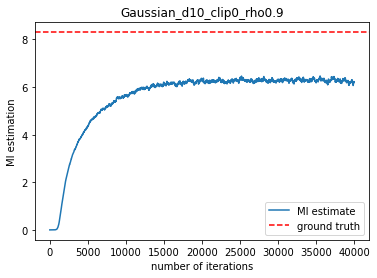

In [26]:
# ma_rate = 0.01
# testmi_copy = testMI_list.copy()
# for k in range(1,len(mi_list)):
#     testmi_copy[k] = (1-ma_rate) * testmi_copy[k-1] + ma_rate * testmi_copy[k]

# plt.plot(testmi_copy, label='MI estimate')
# plt.axhline(Ground_truth,label='ground truth',linestyle='--',color='red')
# for t in range(len(testmi_copy)):
#     if (testmi_copy[t]>.8*Ground_truth):
#         plt.axvline(t,label='80% reached',linestyle=':',color='green')
#         break
# plt.xlabel('number of iterations')
# plt.ylabel('MI estimation')
# plt.title('{}_d{}_clip{}_rho{}'.format(density, opt.d, opt.gamma, opt.rho))
# plt.legend()
# # plt.savefig('./results/DIEM/{}_d{}_clip{}_rho{}.pdf'.format(density, opt.d, opt.gamma, opt.rho))
# # plt.savefig('./results/DIEM/NoClip{}_d{}_smooth{}_rho{}.pdf'.format(density, opt.d, opt.confidence, opt.rho))

In [ ]:
# torch.save(testmi_copy, './TestAdapLS_PCM{}.pth'.format(opt.sample_size))